# Calculs asynchrones

Dans cette séance, vous utiliserez le module `dask` qui fournit une API simple pour paralléliser des calculs même dans le cas où le cadre Map-Reduce ne s'applique pas.

**Question.** Implémentez une fonction `slowadd` qui prend en entrée deux nombres et en retourne la somme, après avoir attendu une seconde (se fait via la fonction `sleep` du module `time`). Utilisez cette fonction pour calculer la somme $(3+7)$ et vérifiez que le calcul prend environ une seconde à s'exécuter. N'utilisez pas `dask` pour le moment.

In [1]:
%%time
from time import sleep

def slowadd(a, b):
    sleep(1)
    return a + b

slowadd(3, 7)

CPU times: user 504 µs, sys: 612 µs, total: 1.12 ms
Wall time: 1 s


10

**Question.** Répétez l'opération en rendant votre appel à la fonction `slowadd` asynchrone à l'aide de [`dask.delayed`](https://docs.dask.org/en/stable/delayed-api.html#dask.delayed.delayed). Combien de temps prendra le calcul cette fois-ci ? Vérifiez.

In [2]:
%%time
import dask

slowadd_delayed = dask.delayed(slowadd)
slowadd_delayed(3, 7).compute()


CPU times: user 44.2 ms, sys: 8.8 ms, total: 53 ms
Wall time: 1.06 s


10

**Question.** Supposons que l'on dispose d'une liste `li = [1, 7, 9, 2]` et que l'on souhaite utiliser `slowadd` pour calculer $(3+x)$ où $x$ prend successivement chacune des valeurs de la liste `li`. Combien de temps prendra ce calcul si l'on ne met pas en place de stratégie de calcul parallèle ? Vérifiez.

In [3]:
%%time
li = [1, 7, 9, 2]

[slowadd(3, x) for x in li]

CPU times: user 1.07 ms, sys: 1.32 ms, total: 2.39 ms
Wall time: 4.01 s


[4, 10, 12, 5]

**Question.** Reprenez maintenant le code ci-dessus utilisant `dask.delayed` pour permettre l'exécution des calculs de la question précédente en parallèle. Combien de temps prendra le calcul cette fois ? Vérifiez.

In [4]:
%%time
li = [1, 7, 9, 2]

dask.delayed([slowadd_delayed(3, x) for x in li]).compute()

CPU times: user 3.39 ms, sys: 2.46 ms, total: 5.85 ms
Wall time: 1.01 s


[4, 10, 12, 5]

## Exercice

Jetez un oeil au code ci-dessous. On aimerait le rendre asynchrone en retardant l'exécution de certaines fonctions, mais pas toutes.
Dans cet exemple, on itère sur une liste d'entiers. 
Si l'entier courant est pair, alors on souhaite appeler la fonction `half`, sinon, on veut appeler `odd_process`. 

Quelle(s) fonction faut-il décorer avec `dask.delayed` pour atteindre un temps d'exécution le plus court possible ? Quel devrait être le temps d'exécution ? Vérifiez.

In [5]:
import dask.delayed

def half(x):
    sleep(1)
    return x // 2

def odd_process(x):
    sleep(1)
    return 3*x+1

def is_even(x):
    return not x % 2

data = list(range(8))

result = []
for x in data:
    if is_even(x):
        result.append(half(x))
    else:
        result.append(odd_process(x))

total = sum(result)

In [6]:
%%time
# Proposition de correction
import dask.delayed

@dask.delayed
def half(x):
    sleep(1)
    return x // 2

@dask.delayed
def odd_process(x):
    sleep(1)
    return 3*x+1

def is_even(x):
    return not x % 2

data = list(range(8))

result = []
for x in data:
    if is_even(x):
        result.append(half(x))
    else:
        result.append(odd_process(x))

total = sum(result).compute()

CPU times: user 9.65 ms, sys: 3.88 ms, total: 13.5 ms
Wall time: 1.01 s


**Question.** Visualisez le graphe de calcul et faites le lien avec les calculs effectués.

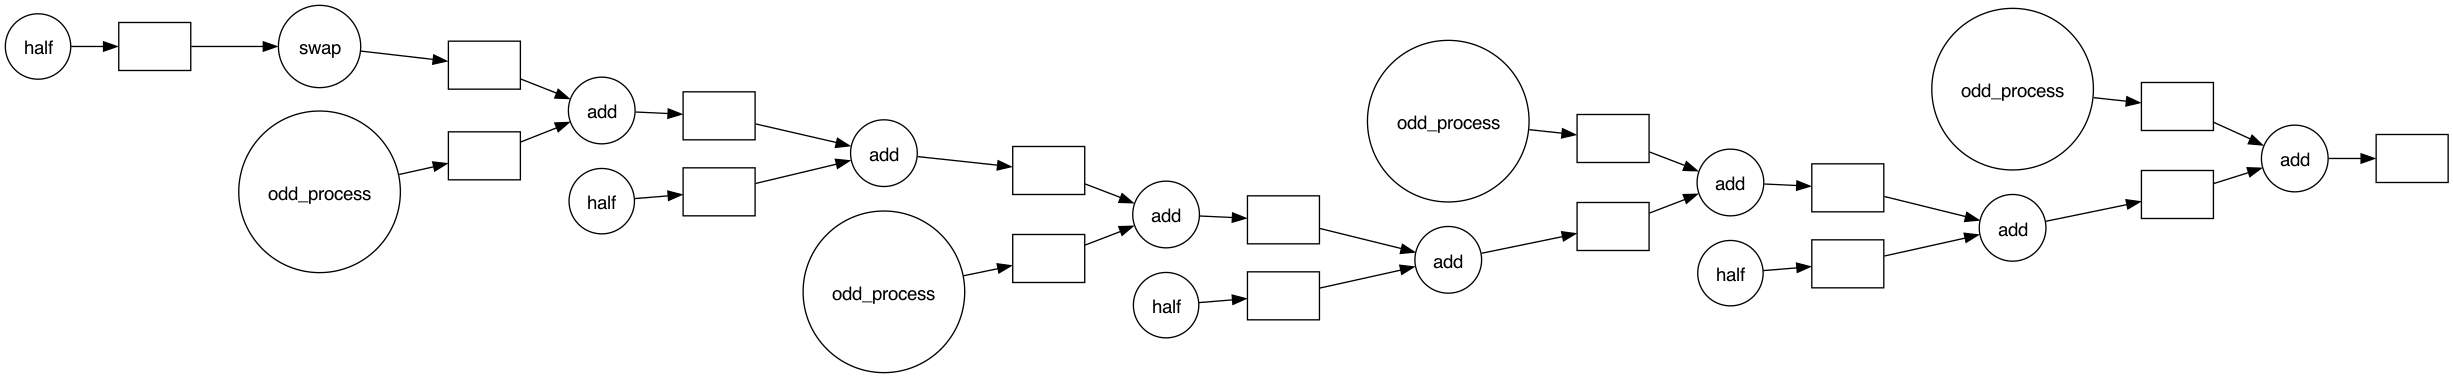

In [7]:
sum(result).visualize(rankdir="LR")

## Bonnes pratiques

Dans la suite, nous verrons non pas des nouvelles fonctionnalités de `dask` mais plutôt des bonnes pratiques relatives à son utilisation.

### 1. Appeler `delayed` sur une fonction, pas sur sa valeur de retour

**Question.** Jetez un oeil aux deux morceaux de code suivants. Quelle différence voyez-vous ? Pourquoi cette différence est importante ? Quel temps de calcul aurons nous pour chacune des deux variantes ?

In [8]:
%%time

def slowadd(a, b):
    sleep(1)
    return a + b

li = [1, 7, 9, 2]

l = [dask.delayed(slowadd(3, x)) for x in li]
sum(l).compute()

CPU times: user 5.98 ms, sys: 2.6 ms, total: 8.57 ms
Wall time: 4.02 s


31

In [9]:
%%time

def slowadd(a, b):
    sleep(1)
    return a + b

li = [1, 7, 9, 2]

l = [dask.delayed(slowadd)(3, x) for x in li]
sum(l).compute()

CPU times: user 4.55 ms, sys: 2.91 ms, total: 7.46 ms
Wall time: 1.01 s


31

### 2. Attendre d'avoir beaucoup de calculs avant de les lancer

Pour améliorer le parallélisme, il est préférable de lancer de nombreux calculs à la fois plutôt que de lancer les calculs un à un.

**Question.** Parmi les deux implémentations suivantes, laquelle est la plus souhaitable ?

In [10]:
results = []

for x in li:
    y = dask.delayed(slowadd)(3, x)
    results.append(y.compute())

results

[4, 10, 12, 5]

In [11]:
results = []

for x in li:
    y = dask.delayed(slowadd)(3, x)
    results.append(y)

dask.delayed(results).compute()

[4, 10, 12, 5]

### 3. Multiplier les tâches...

Le principe de fonctionnement de `dask.delayed` est de permettre de paralléliser plusieurs appels de fonctions `delayed`.

**Question.** En conséquence, quelle(s) fonction(s) faut-il décorer d'un `dask.delayed` dans le code ci-dessous pour obtenir des gains dûs à la parallélisation ?
* Uniquement la fonction `truc` ?
* Toutes les fonctions `machin`, `chose` et `bidule` ?

In [12]:
def machin():
    sleep(1)
    return 12

def chose():
    sleep(1)
    return 13

def bidule():
    sleep(1)
    return 23

def truc(x):
    s = 0
    for i in range(x):
        s += 3 * machin() + 2 * chose() + bidule()
    return s

truc(5)

425

### 4. ... mais pas trop quand même

À chaque création de tâche `delayed` va correspondre un petit délai supplémentaire. Il faut donc éviter de découper trop finement vos jobs. Un bon moyen pour faire cela est d'utiliser les objets `dask` (ici un `dask.array` dans lesquels `dask` fera les calculs par lots, aussi appelés _chunks_).

On évitera donc :

```python
results = []
for x in range(10000000):
    y = dask.delayed(slowadd)(3, x)
    results.append(y)
```

Et on préférera :

In [13]:
%%time

import dask.array as da

b = da.arange(10000000, chunks=1000)
b = b.map_blocks(lambda x: slowadd(3, x))
b[:10].compute()

CPU times: user 1.89 s, sys: 2.16 s, total: 4.05 s
Wall time: 3.27 s


array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12])